In [61]:
import csv
import pandas as pd
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
from functools import reduce
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm

In [68]:
file_names = sorted(glob.glob('/Users/davidchen/Documents/GitHub/Topology/amc_topology/Dataset/*.csv', recursive=True))

In [69]:
unique_sites = [x.strip() for x in list(set([x.split("/")[-1].split("-")[0] for x in file_names]))]

# Function

In [44]:
def topology(name, node, edge, isolated_n=3):
    
    #Read Data 
    
    with open(node, 'r') as nodecsv: # Open the file
        nodereader = csv.reader(nodecsv) # Read the csv
        # Retrieve the data (using Python list comprhension and list slicing to remove the header row, see footnote 3)
        nodes = [n for n in nodereader][1:]

    node_names = [n[0] for n in nodes] # Get a list of only the node names
    
    with open(edge, 'r') as edgecsv: # Open the file
        edgereader = csv.reader(edgecsv) # Read the csv
        edges = [tuple(e[0:2]) for e in edgereader][1:] # Retrieve the data
        edges = [x for x in edges if x[0] != x[1]] # Remove circular edges; link to itself
        
    #Build Network
    
    G = nx.Graph()
    G.add_nodes_from(node_names)
    G.add_edges_from(edges)

    #Remove isolated components
    
    G.remove_nodes_from(list(nx.isolates(G)))

    for component in list(nx.connected_components(G)):
        if len(component)<isolated_n:
            for node in component:
                G.remove_node(node)
                
    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')
    
    #Network-wide metrics
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G)
    diameter = nx.diameter(G)
    transitivity = nx.transitivity(G)
    avg_clustering = nx.average_clustering(G)
    
    network_df = pd.DataFrame(columns = ['Name', 'Nodes', 'Edges', 'Density', 'Diameter', 'Transitivity', 'Average Clustering'])       
    network_df.loc[len(network_df), :] = [name, n_nodes, n_edges, density, diameter, transitivity, avg_clustering]
    
    if os.path.isfile("summary_network_metrics.tsv") is True:
        network_df.to_csv("summary_network_metrics.tsv", sep="\t", header=False, index=False, mode="a")
    else:
        network_df.to_csv("summary_network_metrics.tsv", sep="\t", index=False, mode="w")
        
    #Node-specific metrics
    betweenness = nx.betweenness_centrality(G, normalized=False)
    eigenvector = nx.eigenvector_centrality(G)
    closeness = nx.closeness_centrality(G)
    eccentricity = nx.eccentricity(G)
    pr = nx.pagerank(G, alpha=0.85)
    
    nx.set_node_attributes(G, betweenness, 'betweenness')
    nx.set_node_attributes(G, eigenvector, 'eigenvector')
    nx.set_node_attributes(G, closeness, 'closeness')
    nx.set_node_attributes(G, eccentricity, 'eccentricity')
    nx.set_node_attributes(G, pr, 'pagerank')
    
    betweenness_df = pd.DataFrame.from_dict(data = betweenness.items())
    betweenness_df.columns = ['Node', 'Betweenness']

    eigenvector_df = pd.DataFrame.from_dict(data = eigenvector.items())
    eigenvector_df.columns = ['Node', 'Eigenvector']

    closeness_df = pd.DataFrame.from_dict(data = closeness.items())
    closeness_df.columns = ['Node', 'Closeness']

    eccentricity_df = pd.DataFrame.from_dict(data = eccentricity.items())
    eccentricity_df.columns = ['Node', 'Eccentricity']

    pr_df = pd.DataFrame.from_dict(data = pr.items())
    pr_df.columns = ['Node', 'PageRank']
    
    node_metrics_df = reduce(lambda left,right: pd.merge(left,right,on='Node'), [betweenness_df, eigenvector_df, closeness_df, eccentricity_df, pr_df])
    
    node_metrics_df.to_csv(name + "_node_metrics.tsv", sep="\t", index=False)
    
    #Network Visualization
    
    plt.figure(1, figsize=(20,20)) 
    nx.draw(G, 
            pos = nx.spring_layout(G,scale=5, iterations=100),
            node_size = [x*10 for x in list(dict(G.degree).values())],
            edgecolors = "black")
    plt.savefig(name + '_network.png', dpi=300)
    plt.close()

In [70]:
for site in tqdm(unique_sites):
    name = site
    files_matching_name = [s for s in file_names if site in s]

    node = [s for s in files_matching_name if "Node" in s][0]
    edge = [s for s in files_matching_name if "Internal" in s][0]

    if (len(node) > 0) & (len(edge) > 0):

        try:
            topology(name = name, 
                 node = node, 
                 edge = edge, 
                 isolated_n=3)
        except:
            print(name)
    else:
        print(name)

Utah Healthcare


# Metrics Visualization

In [71]:
summary_metrics = pd.read_csv("summary_network_metrics.tsv", sep="\t")

/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_29633/2054497914.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")
/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_29633/2054497914.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")
/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_29633/2054497914.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")
/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_29633/2054497914.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")
/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_29633/205449791

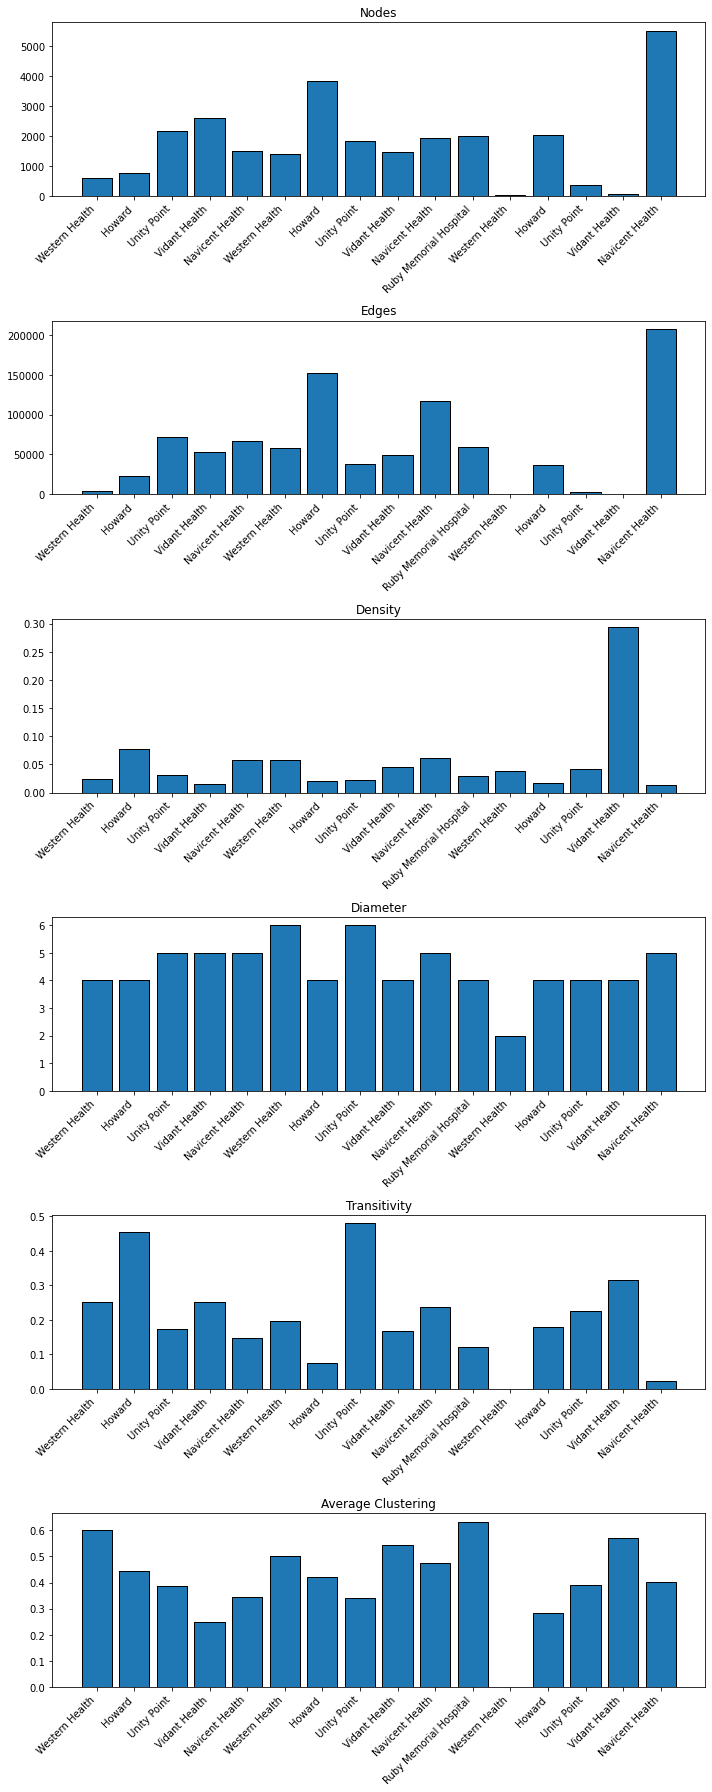

In [90]:
fig, ax = plt.subplots(6, 1, figsize=(10,25))
ax[0].bar(summary_metrics['Name'], summary_metrics['Nodes'], edgecolor="black")
ax[0].set_title("Nodes")
ax[0].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[1].bar(summary_metrics['Name'], summary_metrics['Edges'], edgecolor="black")
ax[1].set_title("Edges")
ax[1].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[2].bar(summary_metrics['Name'], summary_metrics['Density'], edgecolor="black")
ax[2].set_title("Density")
ax[2].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[3].bar(summary_metrics['Name'], summary_metrics['Diameter'], edgecolor="black")
ax[3].set_title("Diameter")
ax[3].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[4].bar(summary_metrics['Name'], summary_metrics['Transitivity'], edgecolor="black")
ax[4].set_title("Transitivity")
ax[4].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[5].bar(summary_metrics['Name'], summary_metrics['Average Clustering'], edgecolor="black")
ax[5].set_title("Average Clustering")
ax[5].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

plt.tight_layout()
plt.show()